# Demo: Cage Clamp Classifier

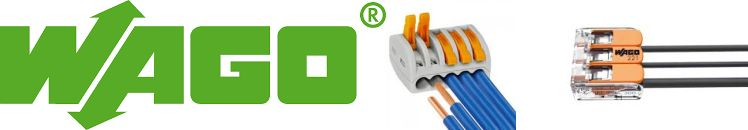

* 4000 Bilder pro Kategorie 
* 4 Kategorien (3000:1000 - Training/Validierung)
* Vergleich: ImageNet bietet mehr als 100K Bilder pro Kategorie
* trotz weniger Bilder eine gute Klassifikation möglich
   
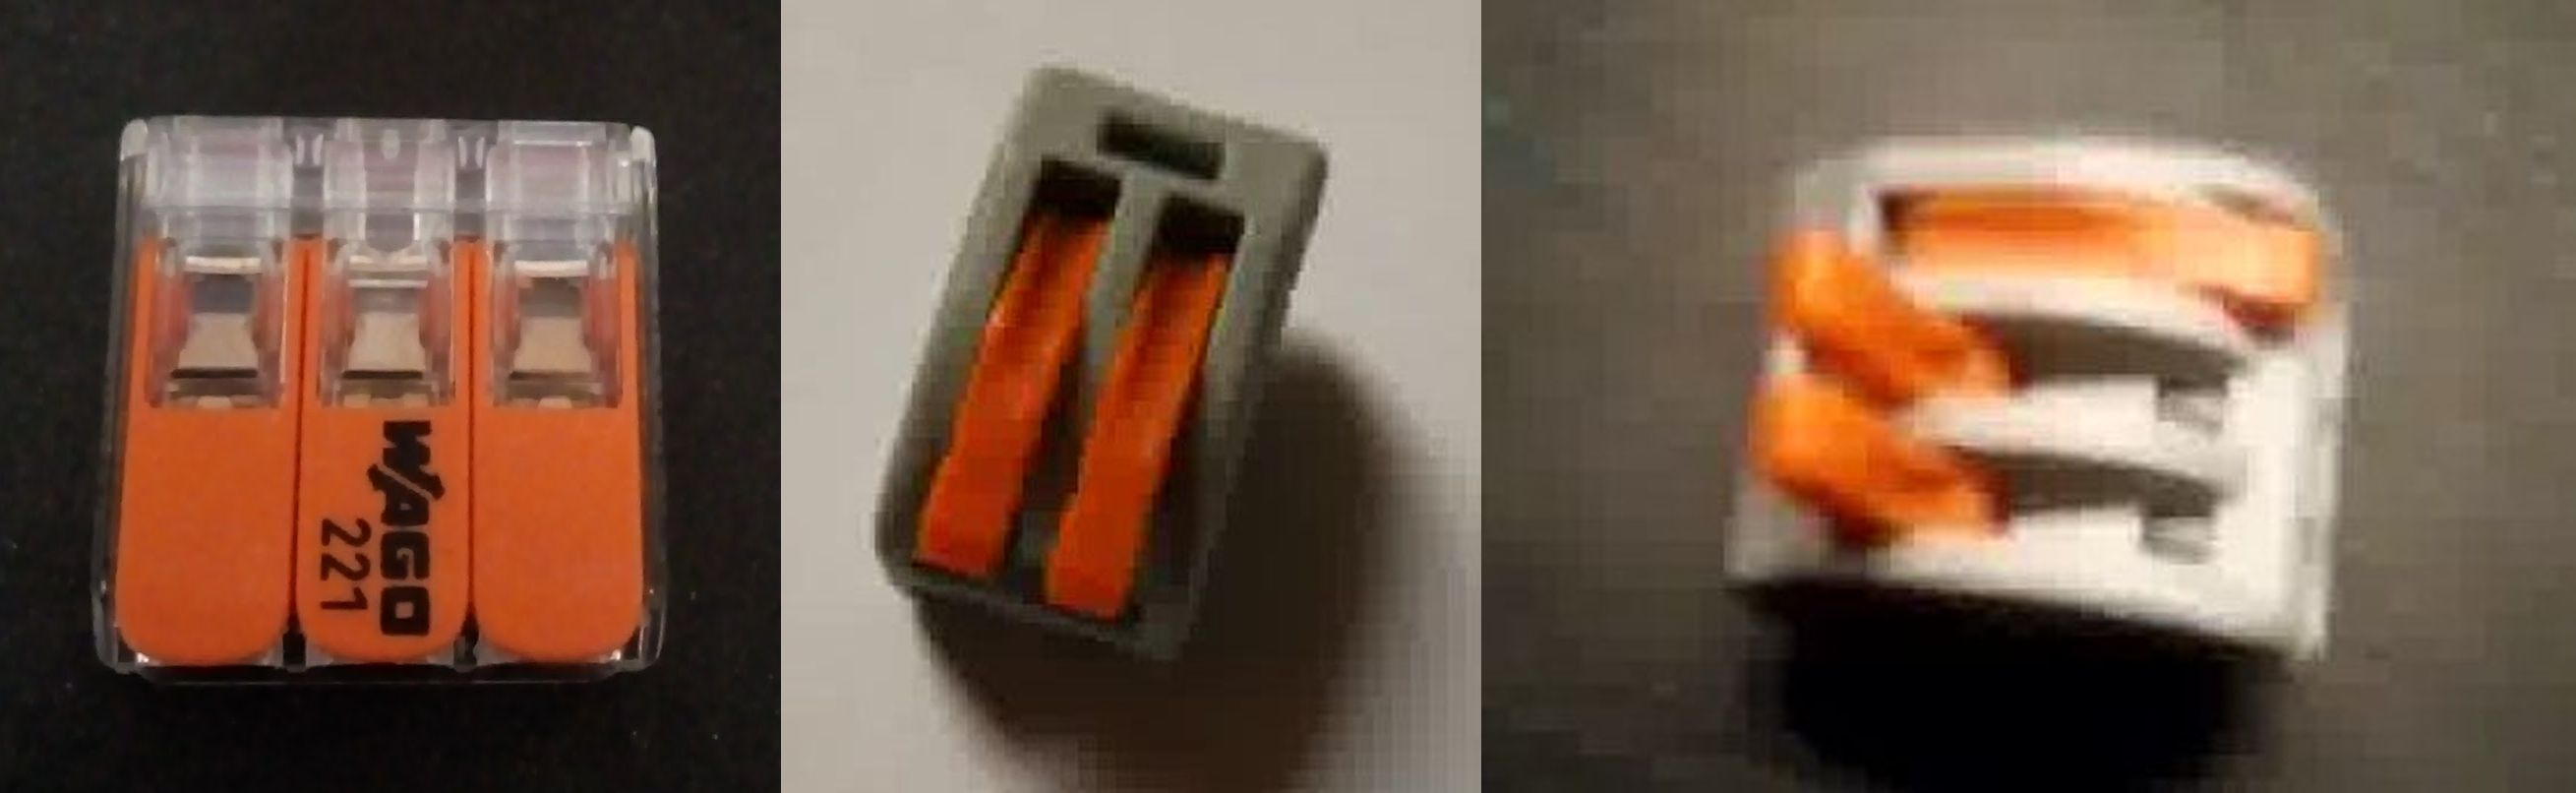
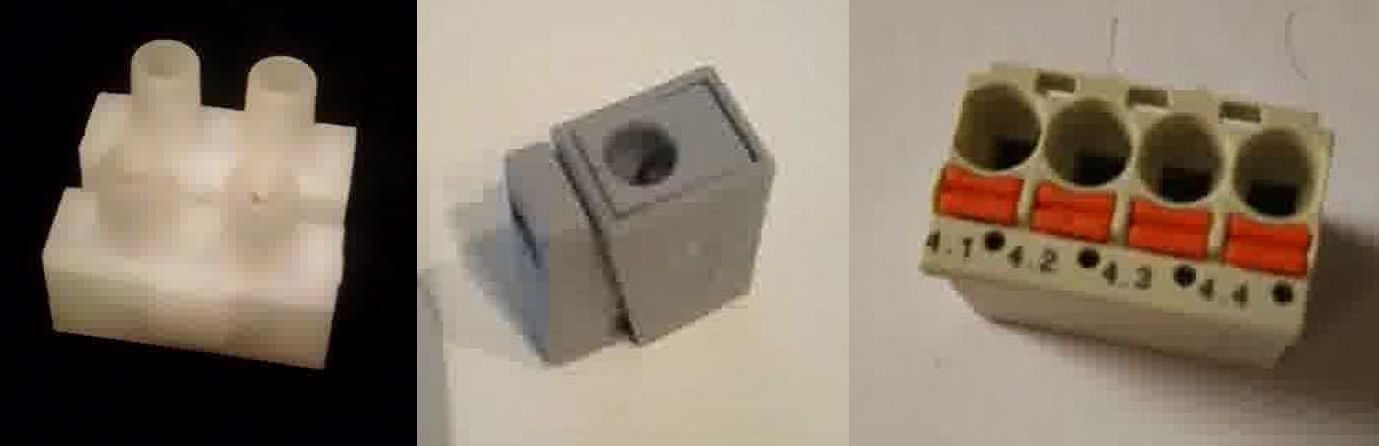


* Verschiedene Architekturen
    * From Scratch
    * MobileNet: Abgespecktes Netz um auf dem Endgerät lauffähig zu bleiben
    * Inception
    
***

# Overfitting bekämpfen durch Image Augmentation
* besonders bei kleinen Datensätzen
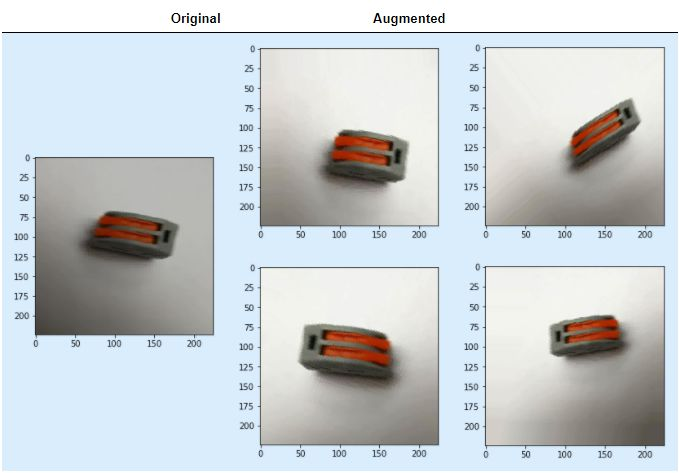

In [2]:
# Beispiel: augmented image data generation 
from keras.preprocessing.image import ImageDataGenerator
train_dir = './data/cage_clamp/samples'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize images
    batch_size=50,
    class_mode='categorical')

print (train_generator.classes)
print (train_generator.class_indices)

Found 14 images belonging to 4 classes.
[0 0 0 0 1 1 1 2 2 2 2 3 3 3]
{'221': 0, '222': 1, 'luster': 2, 'other': 3}


In [27]:
from keras import layers
from keras import models

image_width = 224
image_height = 224

def create_model():
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    
    return model

# DEMO - load model

In [2]:
from keras import optimizers
from keras.models import load_model
model = None
saved_model = None
saved_model = './checkpoints/scratch.050-0.017.hdf5'

if saved_model is None:
    model = create_model()
else :
    print("Loading model %s" % saved_model)
    model = load_model(saved_model)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Loading model ./checkpoints/scratch.050-0.017.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)        

In [34]:
# image augmentation
import os
# training data generator + image augmentation
from keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cage_clamp/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=64,
    class_mode='categorical')

Found 11584 images belonging to 4 classes.
Found 3271 images belonging to 4 classes.


In [ ]:
from keras.callbacks import TensorBoard,ModelCheckpoint

tensorboard = TensorBoard(log_dir='./logs')

checkpointer = ModelCheckpoint(
    filepath='./checkpoints/' +'scratch' + \
        '.{epoch:03d}-{val_loss:.3f}.hdf5',
    verbose=1,
    save_best_only=True)

callbacks = [tensorboard,checkpointer]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=4,
    callbacks=callbacks)

(1, 224, 224, 3)
(1, 54, 54, 64)


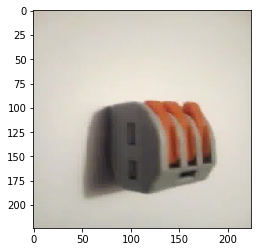

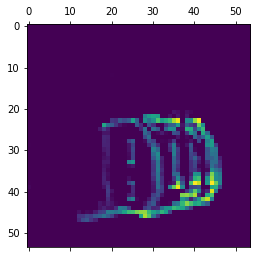

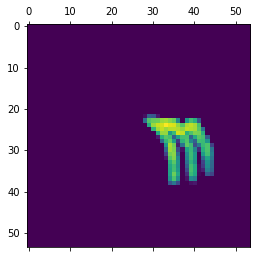

In [26]:
# Visualization: response map

%matplotlib inline

from keras.preprocessing import image
import numpy as np

img_path = './data/cage_clamp/simple/222-2.jpg'

img = image.load_img(img_path, target_size=(224, 224))
image_tensor = image.img_to_array(img)
image_tensor = np.expand_dims(image_tensor, axis=0)
image_tensor /= 255.
print(image_tensor.shape)

# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='model.png')

from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(image_tensor)

first_layer_activation = activations[3]
print(first_layer_activation.shape)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
#plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')
plt.matshow(first_layer_activation[0, :, :, 63], cmap='viridis')

C:\Users\u018413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


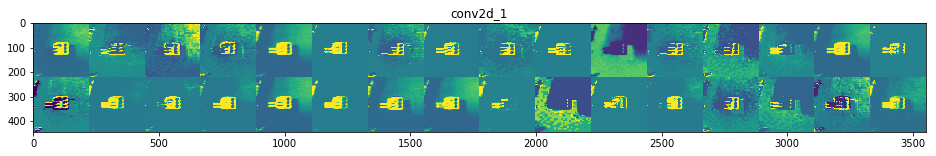

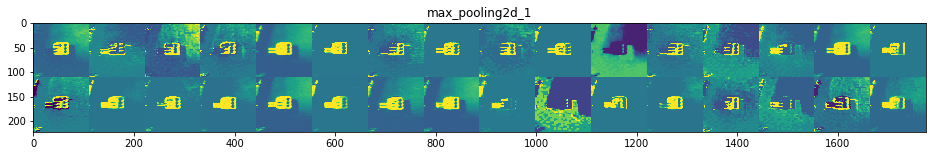

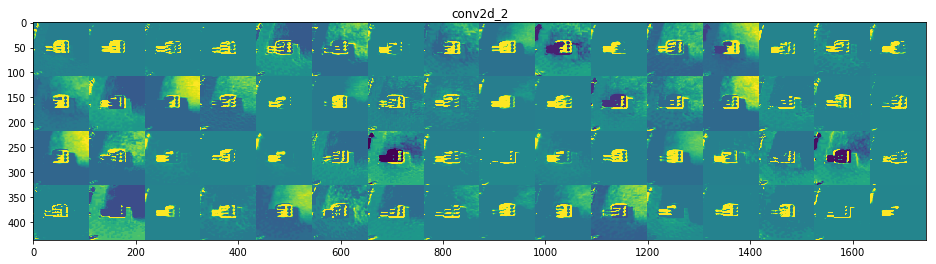

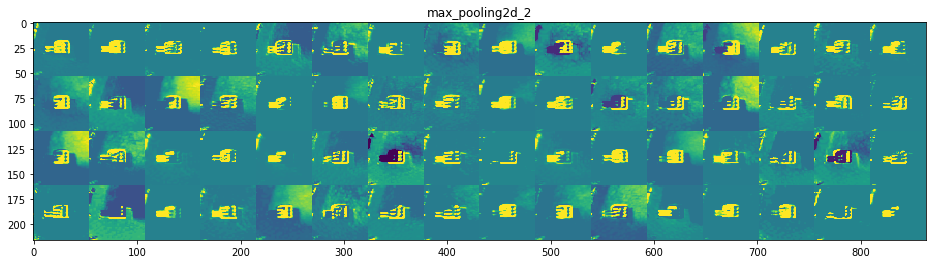

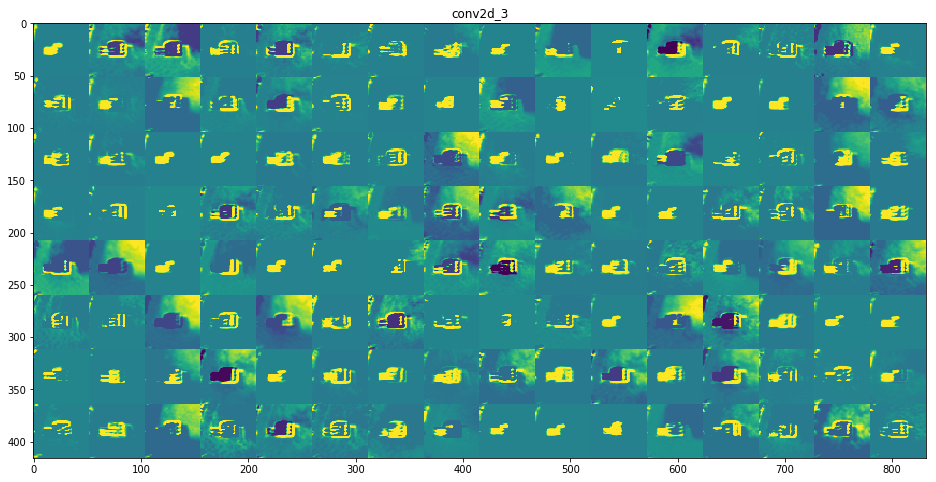

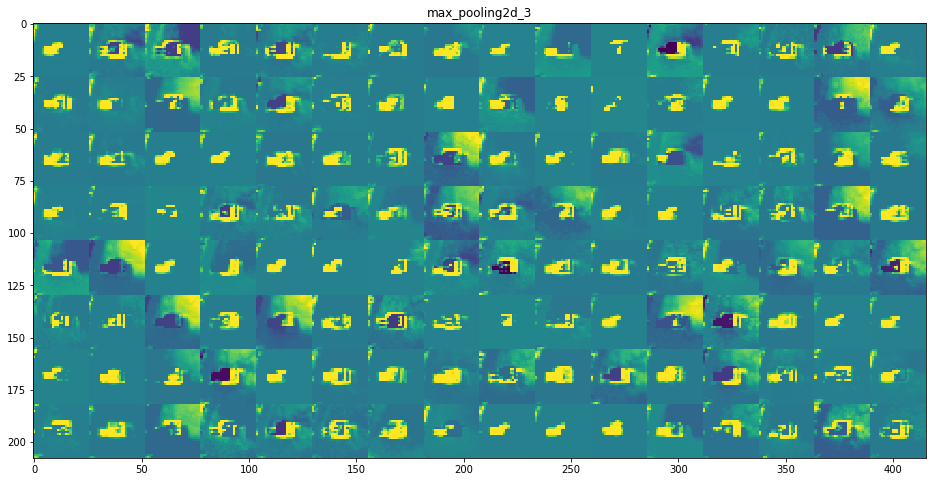

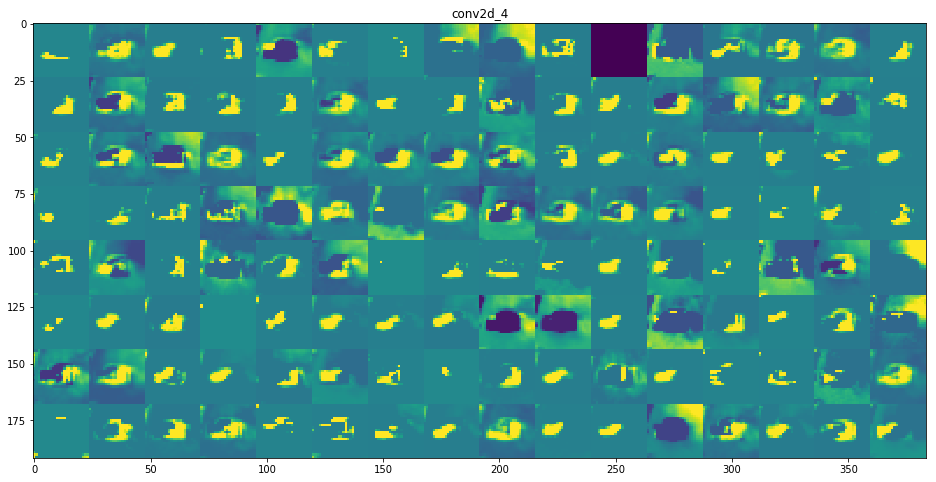

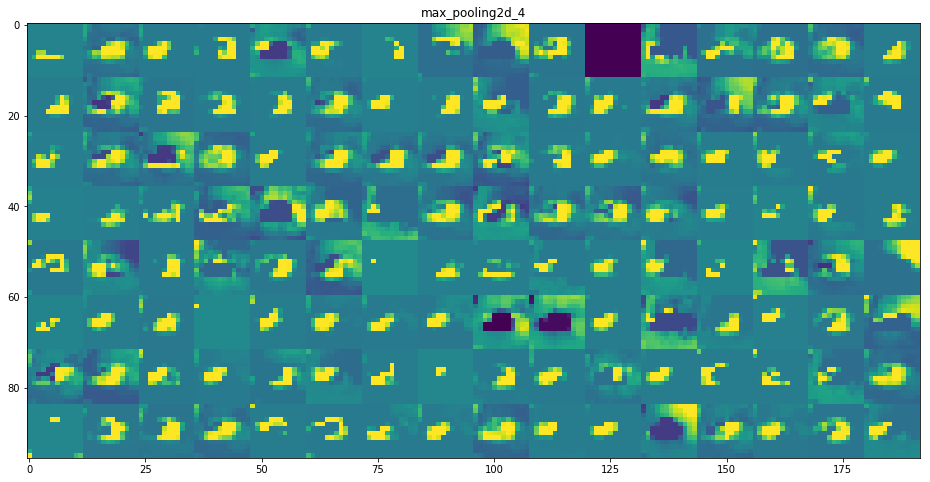

In [42]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[0:8]:
    layer_names.append(layer.name)
images_per_row = 16
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')